# Next-frame prediction with Conv-LSTM

**Author:** [jeammimi](https://github.com/jeammimi)<br>
**Date created:** 2016/11/02<br>
**Last modified:** 2020/05/01<br>
**Description:** Predict the next frame in a sequence using a Conv-LSTM model.

## Introduction

This script demonstrates the use of a convolutional LSTM model.
The model is used to predict the next frame of an artificially
generated movie which contains moving squares.


## Setup


In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pylab as plt


## Build a model

We create a model which take as input movies of shape
`(n_frames, width, height, channels)` and returns a movie
of identical shape.


In [2]:
seq = keras.Sequential(
    [
        keras.Input(
            shape=(None, 40, 40, 1)
        ),  # Variable-length sequence of 40x40x1 frames
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.Conv3D(
            filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
        ),
    ]
)
seq.compile(loss="binary_crossentropy", optimizer="adadelta")


## Generate artificial data

Generate movies with 3 to 7 moving squares inside.
The squares are of shape 1x1 or 2x2 pixels,
and move linearly over time.
For convenience, we first create movies with bigger width and height (80x80)
and at the end we select a 40x40 window.


In [3]:

def generate_movies(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[
                    i, t, x_shift - w : x_shift + w, y_shift - w : y_shift + w, 0
                ] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the model to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1) ** np.random.randint(0, 2)
                    noisy_movies[
                        i,
                        t,
                        x_shift - w - 1 : x_shift + w + 1,
                        y_shift - w - 1 : y_shift + w + 1,
                        0,
                    ] += (noise_f * 0.1)

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[
                    i, t, x_shift - w : x_shift + w, y_shift - w : y_shift + w, 0
                ] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies



## Train the model


In [4]:
epochs = 200

noisy_movies, shifted_movies = generate_movies(n_samples=1200)
seq.fit(
    noisy_movies[:1000],
    shifted_movies[:1000],
    batch_size=10,
    epochs=epochs,
    verbose=2,
    validation_split=0.1,
)


Epoch 1/200
90/90 - 46s - loss: 0.9149 - val_loss: 0.6545
Epoch 2/200
90/90 - 45s - loss: 0.7848 - val_loss: 0.6129
Epoch 3/200
90/90 - 45s - loss: 0.7297 - val_loss: 0.5705
Epoch 4/200
90/90 - 45s - loss: 0.6984 - val_loss: 0.5524
Epoch 5/200
90/90 - 45s - loss: 0.6742 - val_loss: 0.5624
Epoch 6/200
90/90 - 45s - loss: 0.6541 - val_loss: 0.6186
Epoch 7/200
90/90 - 45s - loss: 0.6365 - val_loss: 0.6450
Epoch 8/200
90/90 - 45s - loss: 0.6206 - val_loss: 0.6262
Epoch 9/200
90/90 - 45s - loss: 0.6053 - val_loss: 0.6053
Epoch 10/200
90/90 - 45s - loss: 0.5910 - val_loss: 0.5894
Epoch 11/200
90/90 - 45s - loss: 0.5776 - val_loss: 0.5747
Epoch 12/200
90/90 - 45s - loss: 0.5647 - val_loss: 0.5622
Epoch 13/200
90/90 - 45s - loss: 0.5524 - val_loss: 0.5486
Epoch 14/200
90/90 - 45s - loss: 0.5405 - val_loss: 0.5360
Epoch 15/200
90/90 - 45s - loss: 0.5289 - val_loss: 0.5230
Epoch 16/200
90/90 - 45s - loss: 0.5175 - val_loss: 0.5096
Epoch 17/200
90/90 - 45s - loss: 0.5066 - val_loss: 0.4988
Epoch 

## Test the model on one movie

Feed it with the first 7 positions and then
predict the new positions.


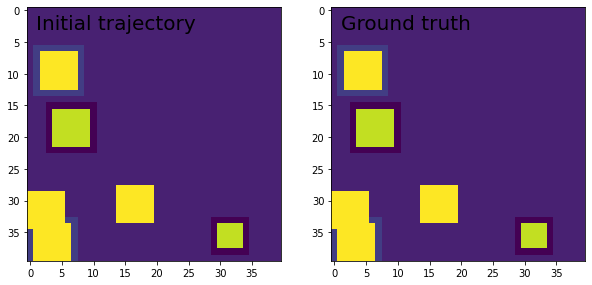

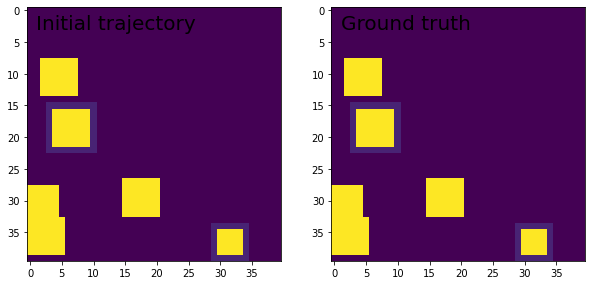

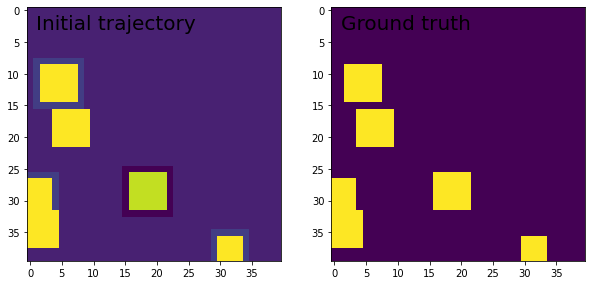

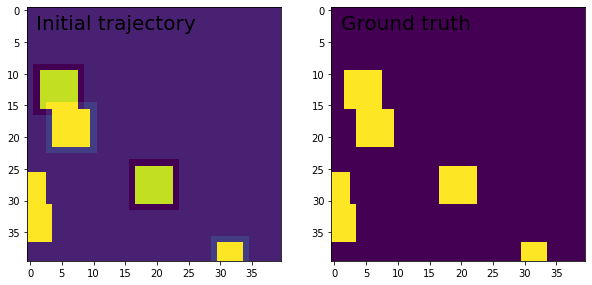

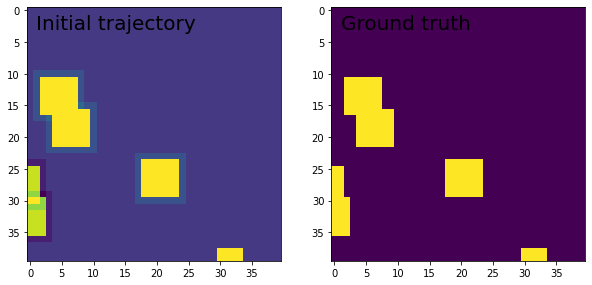

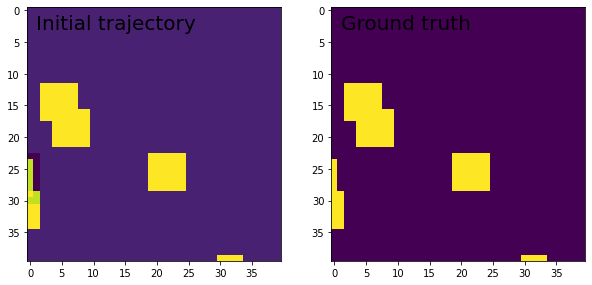

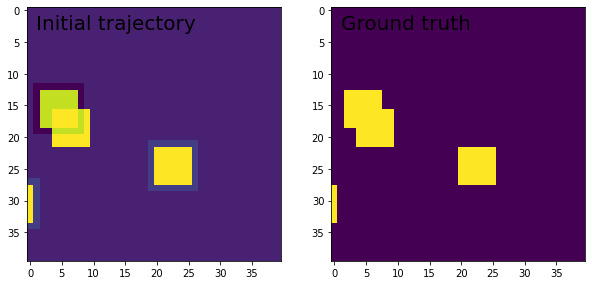

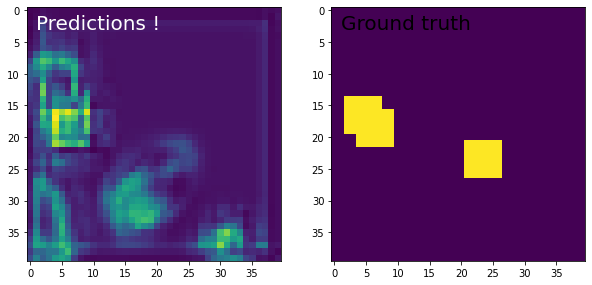

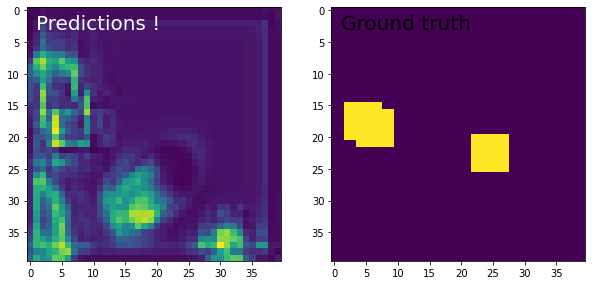

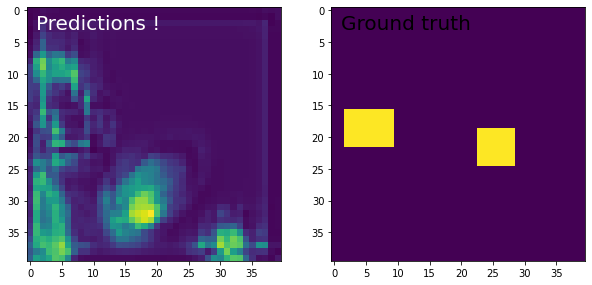

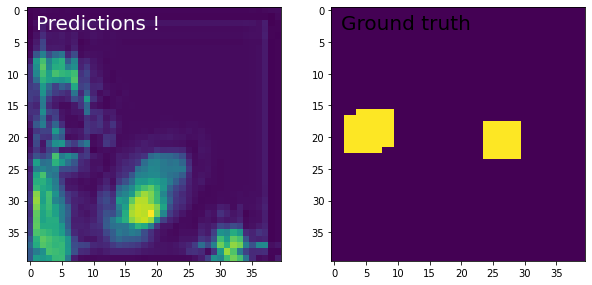

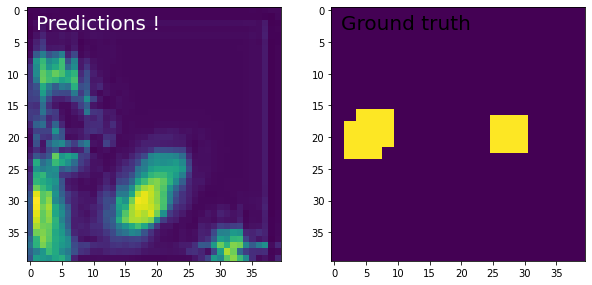

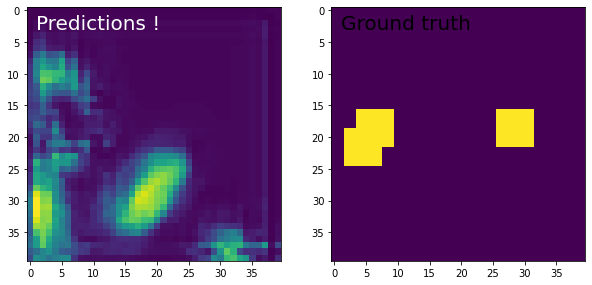

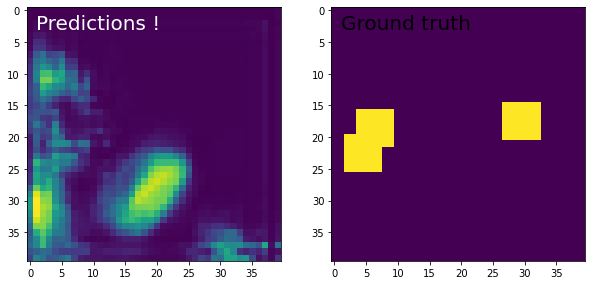

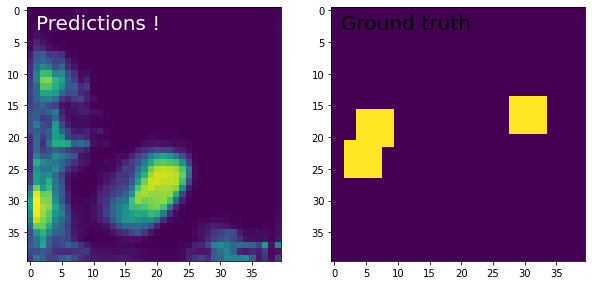

In [5]:
movie_index = 1004
track = noisy_movies[movie_index][:7, ::, ::, ::]

for j in range(16):
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)


# And then compare the predictions
# to the ground truth
track2 = noisy_movies[movie_index][::, ::, ::, ::]
for i in range(15):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= 7:
        ax.text(1, 3, "Predictions !", fontsize=20, color="w")
    else:
        ax.text(1, 3, "Initial trajectory", fontsize=20)

    toplot = track[i, ::, ::, 0]

    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, "Ground truth", fontsize=20)

    toplot = track2[i, ::, ::, 0]
    if i >= 2:
        toplot = shifted_movies[movie_index][i - 1, ::, ::, 0]

    plt.imshow(toplot)
    # plt.savefig("%i_animate.png" % (i + 1))
